In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [2]:
df_results = pd.read_csv("./processed_csvs/classification.csv")


def convert_to_float_list(string_list):
    return [float(x) for x in string_list.strip("[]").split(", ")]


# Apply the function to the 'probabilities' column
df_results["probabilities"] = df_results["probabilities"].apply(convert_to_float_list)
df_results["positive_probabilities"] = [p[1] for p in df_results["probabilities"]]
all_datasets = df_results["dataset"].unique()
all_models = df_results["model"].unique()
all_annotators = df_results["annotator"].unique()
df_results = df_results.sort_values(by=["dataset", "model", "annotator"])
all_auroc = []

df_list = []

for dataset in all_datasets:
    for model in all_models:
        for annotator in all_annotators:
            df = df_results[
                (df_results["dataset"] == dataset)
                & (df_results["model"] == model)
                & (df_results["annotator"] == annotator)
            ].copy()
            labels = df["gold_class"].unique()
            auroc = roc_auc_score(df["gold_class"], df["positive_probabilities"])
            df["auroc"] = auroc
            df_list.append(df)

df_results = pd.concat(df_list)
df_results = df_results.drop(["instance", "probabilities"], axis=1)

df_results_grouped = (
    df_results.groupby(["task_type", "dataset", "model", "annotator"])
    .mean()
    .reset_index()
)

In [3]:
df_results_grouped

,task_type,dataset,model,annotator,id,gold_class,positive_probabilities,auroc
0,classification,asthma_classification,Llama-2-13b-chat,Annotator_1,235.0,0.144374,0.292143,0.933878
1,classification,asthma_classification,Llama-2-13b-chat,Annotator_10,235.0,0.144374,0.260607,0.875639
2,classification,asthma_classification,Llama-2-13b-chat,Annotator_11,235.0,0.144374,0.246471,0.926544
3,classification,asthma_classification,Llama-2-13b-chat,Annotator_12,235.0,0.144374,0.255733,0.986608
4,classification,asthma_classification,Llama-2-13b-chat,Annotator_2,235.0,0.144374,0.858525,0.917457
...,...,...,...,...,...,...,...,...
835,classification,obesity_classification,mistral-7b,Annotator_5,223.0,0.429530,0.317079,0.962296
836,classification,obesity_classification,mistral-7b,Annotator_6,223.0,0.429530,0.346190,0.978758
837,classification,obesity_classification,mistral-7b,Annotator_7,223.0,0.429530,0.399105,0.960437
838,classification,obesity_classification,mistral-7b,Annotator_8,223.0,0.429530,0.252688,0.954677


In [3]:
ORDER_MAP = {
    "Llama-2-7b-chat-hf": 1,
    "asclepius": 2,
    "Llama-2-13b-chat": 3,
    "clinical-camel-7b": 4,
    "alpaca-7b": 5,
    "medalpaca-7b": 6,
    "mistral-7b": 0,
}

colors = sns.color_palette("deep", 10, desat=0.8)
COLOR_MAP = {
    "Mistral (7b)": colors[-2],
    "Llama-2 (7b)": colors[0],
    "Llama-2 (13b)": colors[2],
    "Alpaca (7b)": colors[8],
    "Asclepius (7b)": colors[1],
    "Clin-Camel (13b)": colors[3],
    "MedAlpaca (7b)": colors[9],
}

COLOR_MAP_LOWER = {
    "mistral-7b": colors[7],
    "Llama-2-7b-chat-hf": colors[1],
    "Llama-2-13b-chat": colors[0],
    "alpaca-7b": colors[3],
    "asclepius": colors[1],
    "clinical-camel-7b": colors[0],
    "medalpaca-7b": colors[3],
}

df_results_grouped["order"] = df_results_grouped["model"].apply(lambda x: ORDER_MAP[x])
df_results_grouped = df_results_grouped.sort_values(by=["order"])

In [4]:
MODEL_MAP = {
    "Llama-2-7b-chat-hf": "Llama-2 (7b)",
    "alpaca-7b": "Alpaca (7b)",
    "asclepius": "Asclepius (7b)",
    "clinical-camel-7b": "Clin-Camel (13b)",
    "medalpaca-7b": "MedAlpaca (7b)",
    "mistral-7b": "Mistral (7b)",
    "Llama-2-13b-chat": "Llama-2 (13b)",
}

In [5]:
df_results_grouped = (
    df_results_grouped[["annotator", "dataset", "model", "auroc"]]
    .groupby(["annotator", "model", "dataset"])
    .mean()
    .reset_index()
)
df_results_grouped

,annotator,model,dataset,auroc
0,Annotator_1,Llama-2-13b-chat,asthma_classification,0.933878
1,Annotator_1,Llama-2-13b-chat,cad_classification,0.941008
2,Annotator_1,Llama-2-13b-chat,cohort_abdominal_classification,0.752976
3,Annotator_1,Llama-2-13b-chat,cohort_alcohol_abuse_classification,0.967871
4,Annotator_1,Llama-2-13b-chat,cohort_drug_abuse_classification,0.931727
...,...,...,...,...
835,Annotator_9,mistral-7b,cohort_english_classification,0.997893
836,Annotator_9,mistral-7b,cohort_make_decisions_classification,0.823293
837,Annotator_9,mistral-7b,diabetes_mellitus_classification,0.995413
838,Annotator_9,mistral-7b,mimic_mortality_prediction,0.816249


In [6]:
df_results_grouped_median = (
    df_results_grouped[["model", "dataset", "auroc"]]
    .groupby(["model", "dataset"])
    .median()
    .reset_index()
)


DICT_MEDIANS_CLF = {}

median_values = df_results_grouped_median.values

for model, dataset, median in median_values:
    DICT_MEDIANS_CLF[(model, dataset)] = median

df_results_grouped.columns = ["annotator", "model", "dataset", "auroc"]

df_results_grouped["delta"] = df_results_grouped.apply(
    lambda x: (x["auroc"] - DICT_MEDIANS_CLF[(x["model"], x["dataset"])]), axis=1
)
df_results_grouped

,annotator,model,dataset,auroc,delta
0,Annotator_1,Llama-2-13b-chat,asthma_classification,0.933878,-0.005565
1,Annotator_1,Llama-2-13b-chat,cad_classification,0.941008,-0.010374
2,Annotator_1,Llama-2-13b-chat,cohort_abdominal_classification,0.752976,0.009226
3,Annotator_1,Llama-2-13b-chat,cohort_alcohol_abuse_classification,0.967871,0.034137
4,Annotator_1,Llama-2-13b-chat,cohort_drug_abuse_classification,0.931727,-0.002008
...,...,...,...,...,...
835,Annotator_9,mistral-7b,cohort_english_classification,0.997893,0.002634
836,Annotator_9,mistral-7b,cohort_make_decisions_classification,0.823293,0.090361
837,Annotator_9,mistral-7b,diabetes_mellitus_classification,0.995413,0.006052
838,Annotator_9,mistral-7b,mimic_mortality_prediction,0.816249,0.034354


In [7]:
df_results_grouped = df_results_grouped.sort_values(by=["delta"], ascending=False)

### extraction

In [8]:
df_results_grouped_extraction = pd.read_csv("./processed_csvs/extraction_grouped.csv")

In [9]:
df_results_grouped_extraction

,Unnamed: 0,dataset,model,annotator,precision,recall,f1_score,y_labels,order
0,251,concept_treatment_extraction,mistral-7b,Annotator_9,0.054365,0.534493,0.088848,Mistral (7b),0
1,164,concept_test_extraction,mistral-7b,Annotator_6,0.252016,0.325948,0.196810,Mistral (7b),0
2,165,concept_test_extraction,mistral-7b,Annotator_7,0.281534,0.306763,0.230234,Mistral (7b),0
3,166,concept_test_extraction,mistral-7b,Annotator_8,0.436548,0.332664,0.301261,Mistral (7b),0
4,167,concept_test_extraction,mistral-7b,Annotator_9,0.127491,0.388611,0.130714,Mistral (7b),0
...,...,...,...,...,...,...,...,...,...
415,155,concept_test_extraction,medalpaca-7b,Annotator_9,0.134487,0.218935,0.120260,MedAlpaca (7b),6
416,144,concept_test_extraction,medalpaca-7b,Annotator_1,0.055441,0.280326,0.056807,MedAlpaca (7b),6
417,145,concept_test_extraction,medalpaca-7b,Annotator_10,0.038251,0.276064,0.054811,MedAlpaca (7b),6
418,147,concept_test_extraction,medalpaca-7b,Annotator_12,0.176260,0.267380,0.141807,MedAlpaca (7b),6


In [10]:
df_results_grouped_extraction["y_labels"] = df_results_grouped_extraction[
    "model"
].apply(lambda x: MODEL_MAP[x])

In [11]:
ORDER_MAP = {
    "Llama-2-7b-chat-hf": 1,
    "asclepius": 2,
    "Llama-2-13b-chat": 3,
    "clinical-camel-7b": 4,
    "alpaca-7b": 5,
    "medalpaca-7b": 6,
    "mistral-7b": 0,
}
df_results_grouped_extraction["order"] = df_results_grouped_extraction["model"].apply(
    lambda x: ORDER_MAP[x]
)
df_results_grouped_extraction = df_results_grouped_extraction.sort_values(by="order")

df_results_grouped_extraction

,Unnamed: 0,dataset,model,annotator,precision,recall,f1_score,y_labels,order
0,251,concept_treatment_extraction,mistral-7b,Annotator_9,0.054365,0.534493,0.088848,Mistral (7b),0
32,159,concept_test_extraction,mistral-7b,Annotator_12,0.135879,0.383172,0.146445,Mistral (7b),0
33,81,concept_problem_extraction,mistral-7b,Annotator_7,0.339727,0.409635,0.332981,Mistral (7b),0
34,73,concept_problem_extraction,mistral-7b,Annotator_10,0.150188,0.471370,0.192874,Mistral (7b),0
35,502,risk_factor_cad_extraction,mistral-7b,Annotator_8,0.042997,0.916063,0.065208,Mistral (7b),0
...,...,...,...,...,...,...,...,...,...
384,60,concept_problem_extraction,medalpaca-7b,Annotator_1,0.255418,0.243384,0.202626,MedAlpaca (7b),6
385,61,concept_problem_extraction,medalpaca-7b,Annotator_10,0.268212,0.277825,0.214738,MedAlpaca (7b),6
386,62,concept_problem_extraction,medalpaca-7b,Annotator_11,0.383966,0.260432,0.268020,MedAlpaca (7b),6
388,65,concept_problem_extraction,medalpaca-7b,Annotator_3,0.285115,0.261237,0.217495,MedAlpaca (7b),6


In [12]:
df_results_grouped_extraction = (
    df_results_grouped_extraction[["model", "annotator", "dataset", "f1_score"]]
    .groupby(["model", "annotator", "dataset"])
    .mean()
    .reset_index()
)
df_results_grouped_extraction.columns = ["model", "annotator", "dataset", "score"]

df_results_grouped_extraction_median = (
    df_results_grouped_extraction[["model", "dataset", "score"]]
    .groupby(["model", "dataset"])
    .median()
    .reset_index()
)


DICT_MEDIANS_EXT = {}

median_values = df_results_grouped_extraction_median.values

for model, dataset, median in median_values:
    DICT_MEDIANS_EXT[(model, dataset)] = median


df_results_grouped_extraction["delta"] = df_results_grouped_extraction.apply(
    lambda x: (x["score"] - DICT_MEDIANS_EXT[(x["model"], x["dataset"])]), axis=1
)

In [13]:
df_results_grouped_extraction

,model,annotator,dataset,score,delta
0,Llama-2-13b-chat,Annotator_1,concept_problem_extraction,0.303230,-0.012695
1,Llama-2-13b-chat,Annotator_1,concept_test_extraction,0.169309,-0.032163
2,Llama-2-13b-chat,Annotator_1,concept_treatment_extraction,0.160495,-0.088248
3,Llama-2-13b-chat,Annotator_1,medication_extraction,0.479083,-0.066189
4,Llama-2-13b-chat,Annotator_1,risk_factor_cad_extraction,0.057851,-0.022245
...,...,...,...,...,...
415,mistral-7b,Annotator_9,concept_problem_extraction,0.264797,0.002070
416,mistral-7b,Annotator_9,concept_test_extraction,0.130714,-0.019922
417,mistral-7b,Annotator_9,concept_treatment_extraction,0.088848,-0.053618
418,mistral-7b,Annotator_9,medication_extraction,0.340539,0.009944


In [14]:
ANNOTATOR_EXPERTISE = {
    "Annotator_1": "Yes",
    "Annotator_2": "Yes",
    "Annotator_3": "Yes",
    "Annotator_4": "No",
    "Annotator_5": "Yes",
    "Annotator_6": "Yes",
    "Annotator_7": "No",
    "Annotator_8": "Yes",
    "Annotator_9": "Yes",
    "Annotator_10": "Yes",
    "Annotator_11": "No",
    "Annotator_12": "No",
}

In [15]:
colors = sns.color_palette("deep", 10, desat=0.8)
colors
COLOR_MAP = {
    "Yes": colors[0],
    "No": colors[1],
}

/tmp/ipykernel_71383/2526294931.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["order"] = dataset["annotator"].apply(
/tmp/ipykernel_71383/2526294931.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["experienced"] = dataset["annotator"].apply(
/tmp/ipykernel_71383/2526294931.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

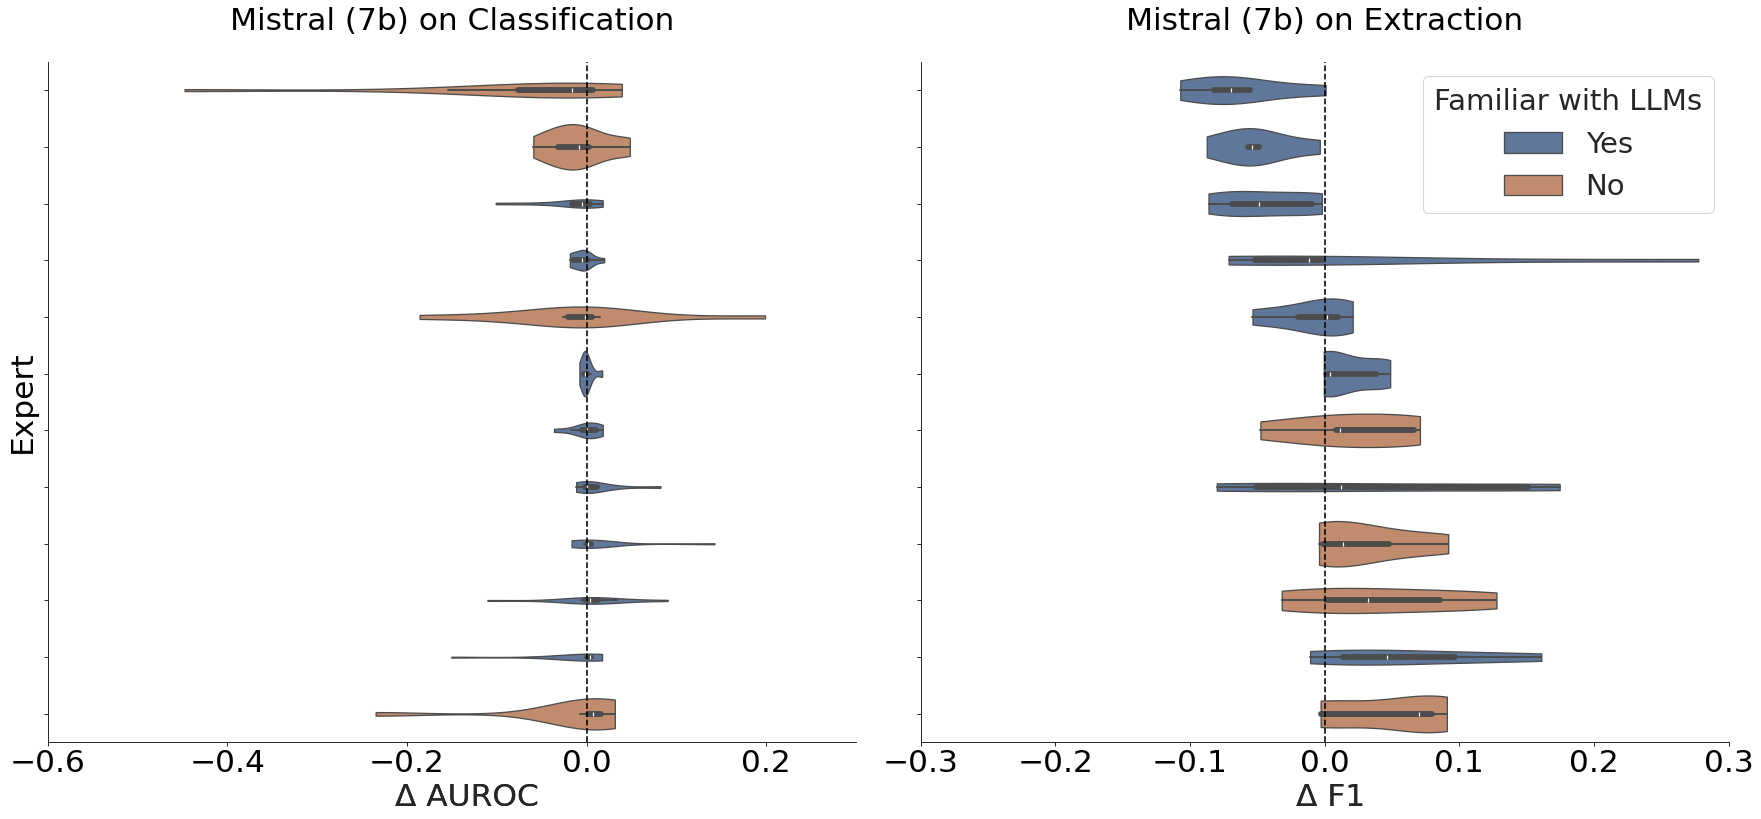

In [16]:
datasets = [
    df_results_grouped,
    df_results_grouped_extraction,
]

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(24, 11), dpi=75, sharex=False, sharey=False
)
sns.set_style("white")
sns.set_context("poster")
sns.set_palette("deep", n_colors=12)
# sns.set_theme(style='white', font_scale=2)
# COLOR_MAP = {
#     "Mistral (7b)": colors[7],
#     "Llama-2 (7b)": colors[1],
#     "Llama-2 (13b)": colors[0],
#     "Alpaca (7b)": colors[3],
#     "Asclepius (7b)": colors[1],
#     "Clin-Camel (13b)": colors[0],
#     "MedAlpaca (7b)": colors[3],
# }
sns.set_theme(style="white", font_scale=2)
fsize = 30

MODEL_MAP = {
    "Llama-2-7b-chat-hf": "Llama-2 (7b)",
    "alpaca-7b": "Alpaca (7b)",
    "asclepius": "Asclepius (7b)",
    "clinical-camel-7b": "Clin-Camel (13b)",
    "medalpaca-7b": "MedAlpaca (7b)",
    "mistral-7b": "Mistral (7b)",
    "Llama-2-13b-chat": "Llama-2 (13b)",
}

model = "mistral-7b"

for idx, dataset in enumerate(datasets):
    # palette = sns.color_palette("blend:#7AB,#EDA")
    palette = sns.color_palette("crest")
    dataset = dataset[dataset["model"] == model]
    dataset_median = (
        dataset[["annotator", "delta"]].groupby(["annotator"]).median().reset_index()
    )

    # order by median
    dataset["order"] = dataset["annotator"].apply(
        lambda x: dataset_median[dataset_median["annotator"] == x]["delta"].values[0]
    )
    dataset["experienced"] = dataset["annotator"].apply(
        lambda x: ANNOTATOR_EXPERTISE[x]
    )
    dataset = dataset.sort_values(by="order")

    mon = sns.violinplot(
        data=dataset,
        y="annotator",
        x="delta",
        cut=0,
        ax=ax[idx],
        hue="experienced",
        palette=COLOR_MAP,
    )
    ax[idx].tick_params(axis="both", labelsize=fsize)
    # sort violinplots by median
    mon.set_yticklabels([], fontsize=18)
    if idx == 0:
        mon.set_ylabel("Expert", fontsize=fsize)
    else:
        mon.set_ylabel(None)

    if idx == 0:
        mon.set_title(f"{MODEL_MAP[model]} on Classification", fontsize=fsize, pad=30)
        # mon.set_xlabel("AUROC", pad=20)
    else:
        mon.set_title(f"{MODEL_MAP[model]} on Extraction", fontsize=fsize, pad=30)
    # mon.set_xlabel("F1 Score", pad=20)
    # add vertical line
    if idx == 0:
        # no legend
        mon.legend_.remove()
    else:
        mon.legend(
            title="Familiar with LLMs",
            loc="upper right",
            fontsize=28,
            title_fontsize=28,
        )
    mon.axvline(0, color="black", linestyle="--")
    fig.text(0.27, 0, "Δ AUROC", ha="center", fontsize=fsize)
    fig.text(0.75, 0, "Δ F1", ha="center", fontsize=fsize)
    # set xticks fontsize
    # plt.legend([], [], frameon=False)
    mon.set(xlabel=None)
    if idx == 0:
        ax[idx].set_xlim(-0.6, 0.3)
    else:
        ax[idx].set_xlim(-0.3, 0.3)
    plt.tight_layout()
    sns.despine(top=True, right=True, left=False, bottom=False)

    plt.savefig(f"annotators_{model}.pdf")

/tmp/ipykernel_71383/1080599624.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["order"] = dataset["annotator"].apply(
/tmp/ipykernel_71383/1080599624.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["experienced"] = dataset["annotator"].apply(
/tmp/ipykernel_71383/1080599624.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

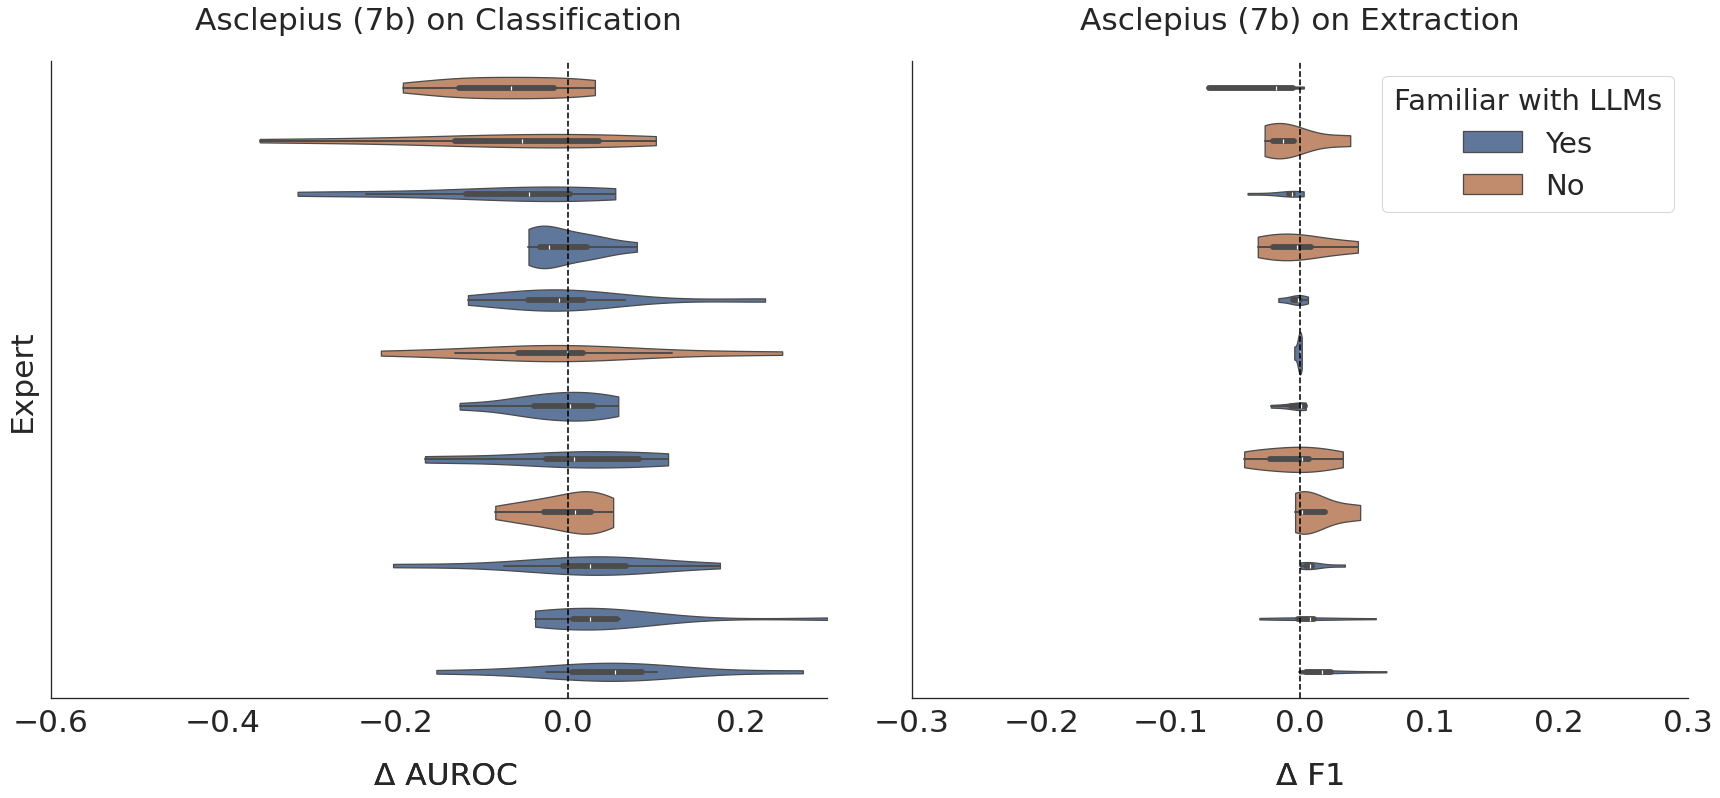

In [17]:
datasets = [
    df_results_grouped,
    df_results_grouped_extraction,
]

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(24, 11), dpi=75, sharex=False, sharey=False
)
sns.set_style("white")
sns.set_context("poster")
sns.set_palette("deep", n_colors=12)
sns.set_theme(style="white", font_scale=1.5)
# sns.set_theme(style='white', font_scale=2)
# COLOR_MAP = {
#     "Mistral (7b)": colors[7],
#     "Llama-2 (7b)": colors[1],
#     "Llama-2 (13b)": colors[0],
#     "Alpaca (7b)": colors[3],
#     "Asclepius (7b)": colors[1],
#     "Clin-Camel (13b)": colors[0],
#     "MedAlpaca (7b)": colors[3],
# }


for idx, dataset in enumerate(datasets):
    # palette = sns.color_palette("blend:#7AB,#EDA")
    palette = sns.color_palette("crest")
    dataset = dataset[dataset["model"] == "asclepius"]
    dataset_median = (
        dataset[["annotator", "delta"]].groupby(["annotator"]).median().reset_index()
    )

    # order by median
    dataset["order"] = dataset["annotator"].apply(
        lambda x: dataset_median[dataset_median["annotator"] == x]["delta"].values[0]
    )
    dataset["experienced"] = dataset["annotator"].apply(
        lambda x: ANNOTATOR_EXPERTISE[x]
    )
    dataset = dataset.sort_values(by="order")
    sns.set_theme(style="white", font_scale=3.5)
    mon = sns.violinplot(
        data=dataset,
        y="annotator",
        x="delta",
        cut=0,
        ax=ax[idx],
        hue="experienced",
        palette=COLOR_MAP,
    )  # sort violinplots by median
    mon.set_yticklabels([], fontsize=18)
    if idx == 0:
        mon.set_ylabel("Expert", fontsize=fsize)
    else:
        mon.set_ylabel(None)
    ax[idx].tick_params(axis="both", labelsize=fsize)
    if idx == 0:
        mon.set_title("Asclepius (7b) on Classification", fontsize=fsize, pad=30)
        # mon.set_xlabel("AUROC", pad=20)
    else:
        mon.set_title("Asclepius (7b) on Extraction", fontsize=fsize, pad=30)
    # mon.set_xlabel("F1 Score", pad=20)
    # add vertical line
    if idx == 0:
        # no legend
        mon.legend_.remove()
    else:
        mon.legend(
            title="Familiar with LLMs",
            loc="upper right",
            fontsize=28,
            title_fontsize=28,
        )
    if idx == 0:
        ax[idx].set_xlim(-0.6, 0.3)
    else:
        ax[idx].set_xlim(-0.3, 0.3)
    mon.axvline(0, color="black", linestyle="--")
    fig.text(0.27, 0, "Δ AUROC", ha="center", fontsize=fsize)
    fig.text(0.75, 0, "Δ F1", ha="center", fontsize=fsize)
    mon.set(xlabel=None)

    plt.tight_layout()
    sns.despine(top=True, right=True, left=False, bottom=False)

    plt.savefig(f"annotators_asc.pdf")

/tmp/ipykernel_71383/1308572743.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["order"] = dataset["annotator"].apply(
/tmp/ipykernel_71383/1308572743.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["order"] = dataset["annotator"].apply(


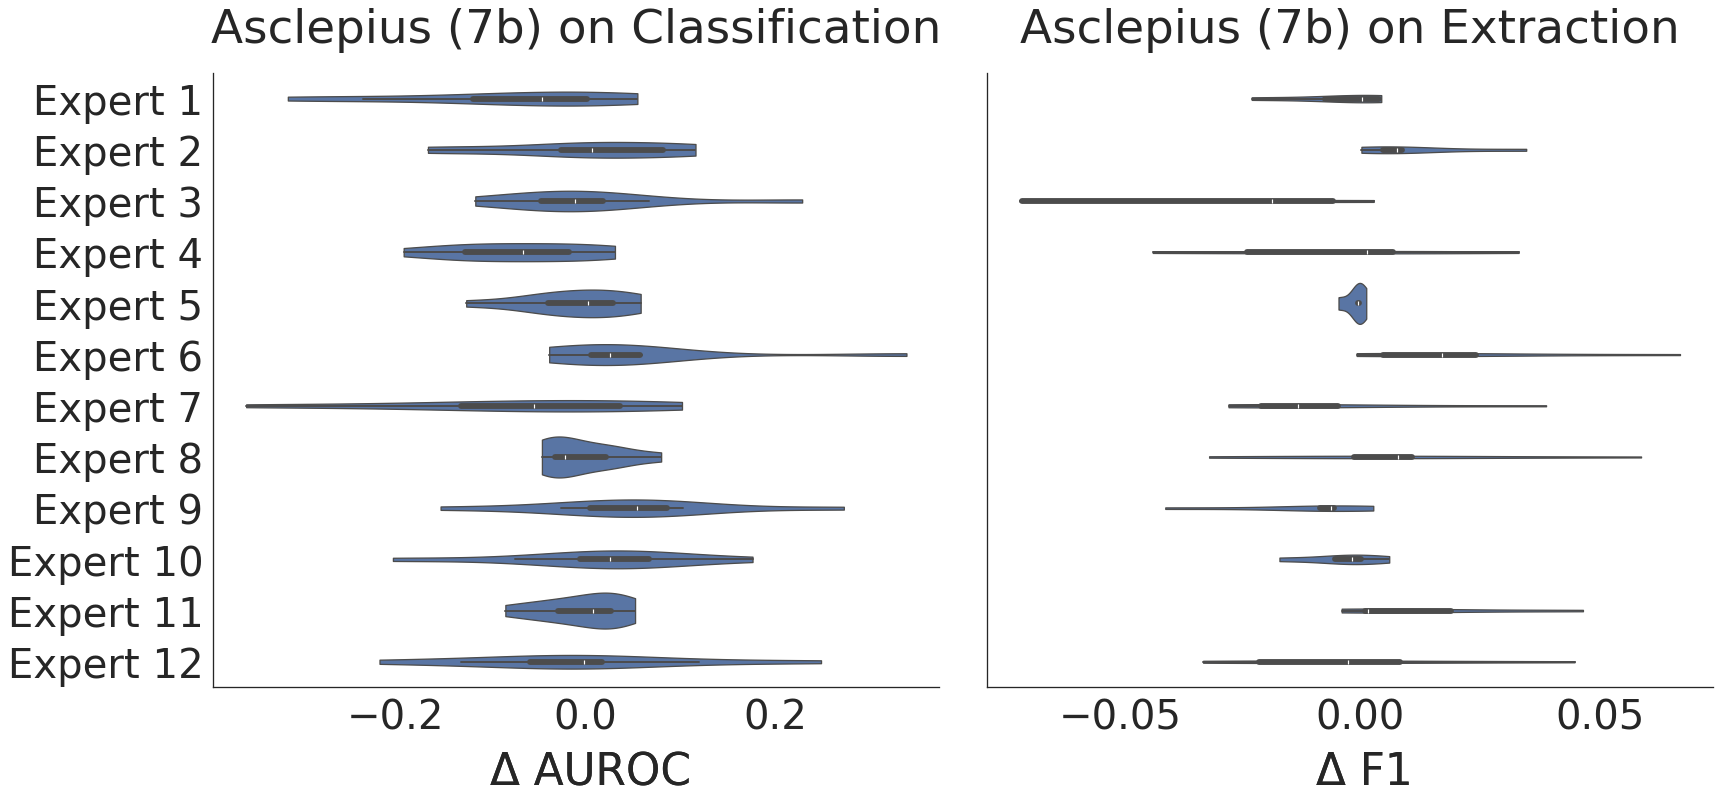

In [18]:
datasets = [
    df_results_grouped,
    df_results_grouped_extraction,
]

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(24, 11), dpi=75, sharex=False, sharey=True
)
sns.set_style("white")
sns.set_context("poster")
sns.set_palette("deep", n_colors=12)
sns.set_theme(style="white", font_scale=4)
# sns.set_theme(style='white', font_scale=2)
# COLOR_MAP = {
#     "Mistral (7b)": colors[7],
#     "Llama-2 (7b)": colors[1],
#     "Llama-2 (13b)": colors[0],
#     "Alpaca (7b)": colors[3],
#     "Asclepius (7b)": colors[1],
#     "Clin-Camel (13b)": colors[0],
#     "MedAlpaca (7b)": colors[3],
# }


for idx, dataset in enumerate(datasets):
    # palette = sns.color_palette("blend:#7AB,#EDA")
    palette = sns.color_palette("crest")
    dataset = dataset[dataset["model"] == "asclepius"]
    dataset["order"] = dataset["annotator"].apply(
        lambda x: int(x.replace("Annotator_", ""))
    )
    dataset = dataset.sort_values(by="order")
    dataset["annotator"] = dataset["annotator"].apply(
        lambda x: x.replace("Annotator_", "Expert ")
    )
    sns.set_theme(style="white", font_scale=3.5)
    mon = sns.violinplot(data=dataset, y="annotator", x="delta", cut=0, ax=ax[idx])
    if idx == 0:
        mon.set_title("Asclepius (7b) on Classification", fontsize=45, pad=30)
        # mon.set_xlabel("AUROC", pad=20)
    else:
        mon.set_title("Asclepius (7b) on Extraction", fontsize=45, pad=30)
    # mon.set_xlabel("F1 Score", pad=20)

    fig.text(0.35, 0, "Δ AUROC", ha="center")
    fig.text(0.78, 0, "Δ F1", ha="center")
    mon.set(xlabel=None)
    mon.set(ylabel=None)
    plt.tight_layout()
    sns.despine(top=True, right=True, left=False, bottom=False)
    plt.savefig(f"annotators_asclepius.pdf")